In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

In [2]:
pos_cash = help_tool.csv_download(r'Archive\home-credit-default-risk\POS_CASH_balance.csv')
help_tool.first_look(pos_cash)

Dataset has 10001358 observations and 8 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_PREV,int64,0,0.0
SK_ID_CURR,int64,0,0.0
MONTHS_BALANCE,int64,0,0.0
CNT_INSTALMENT,float64,26071,0.3
CNT_INSTALMENT_FUTURE,float64,26087,0.3
NAME_CONTRACT_STATUS,object,0,0.0
SK_DPD,int64,0,0.0
SK_DPD_DEF,int64,0,0.0


In [4]:
pos_cash = pos_cash.sample(100000, random_state=42)

MONTHS_BALANCE


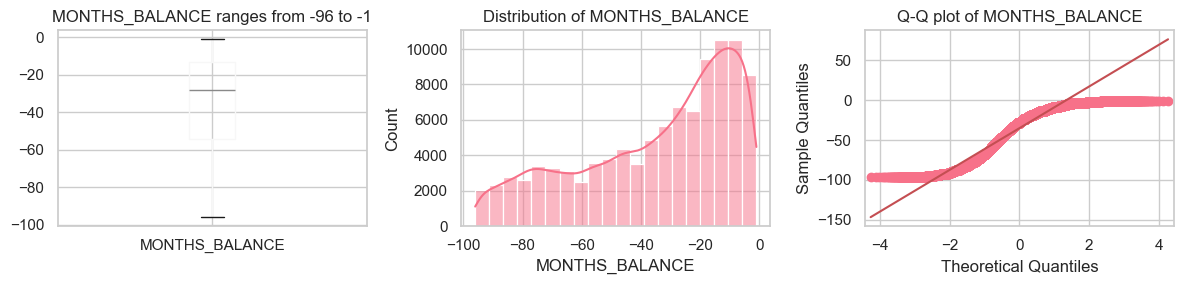

CNT_INSTALMENT


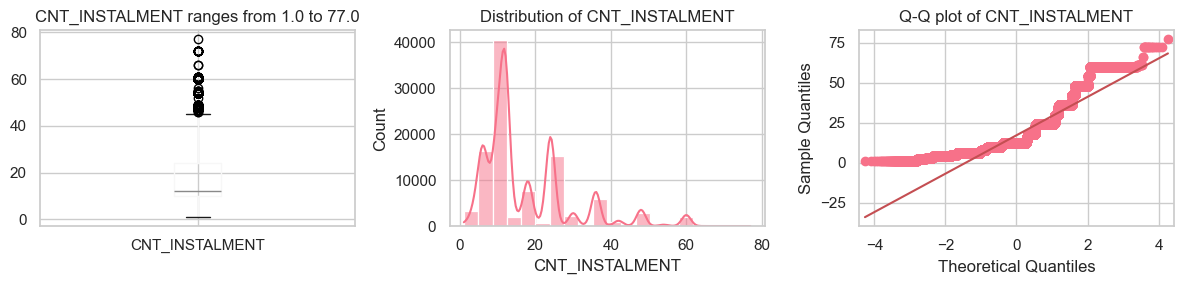

CNT_INSTALMENT_FUTURE


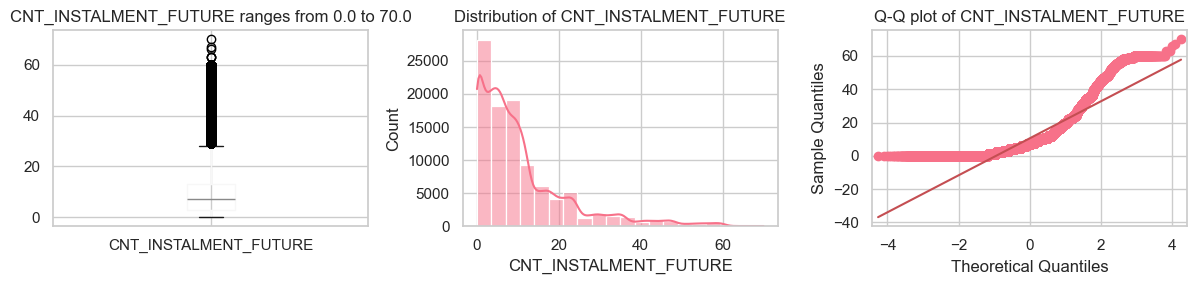

SK_DPD


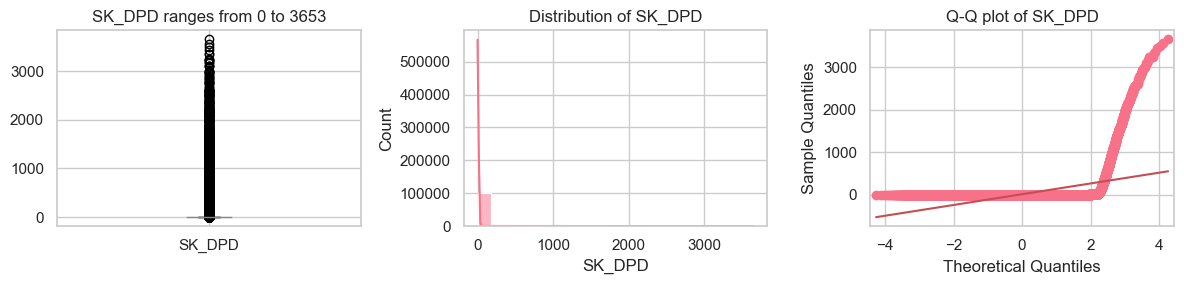

SK_DPD_DEF


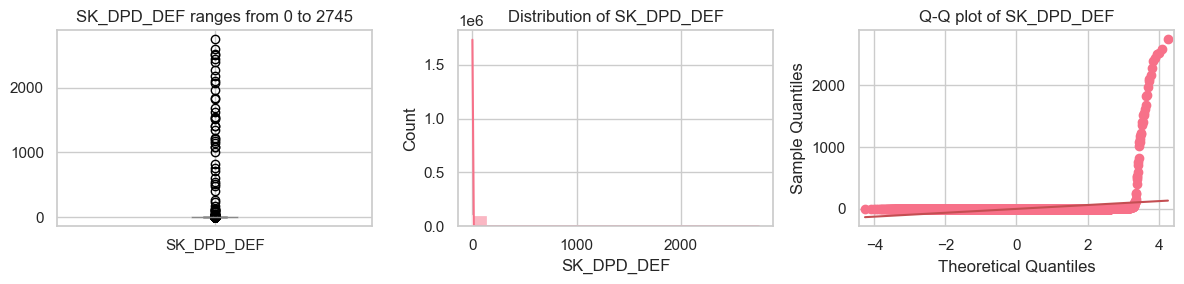

In [3]:
help_visuals.distribution_check(pos_cash.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']))

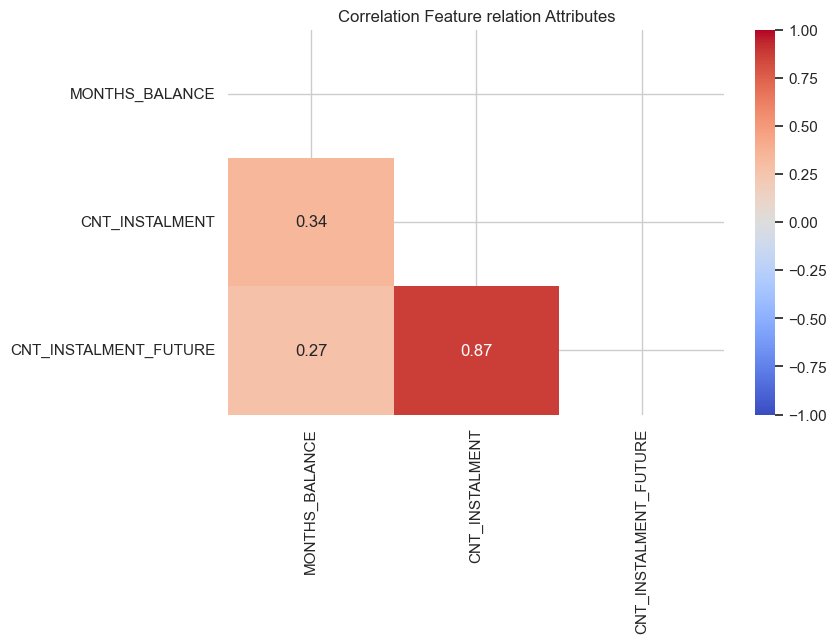

In [10]:
help_visuals.heatmap(pos_cash[['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']], 'Feature relation', 'pearson')

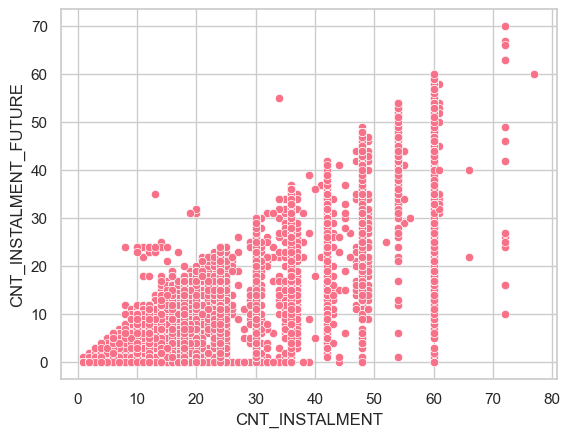

In [12]:
sns.scatterplot(data=pos_cash, x='CNT_INSTALMENT', y='CNT_INSTALMENT_FUTURE')
plt.show()

In [31]:
pos_cash[pos_cash.duplicated(subset=['SK_ID_PREV', 'SK_ID_CURR'], keep=False)]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
203634,2291398,234699,-15,24.0,11.0,Active,0,0
9230008,1095816,415731,-53,24.0,20.0,Active,0,0
1612944,1799911,237060,-76,12.0,10.0,Active,0,0
1038759,1280531,339207,-8,24.0,2.0,Active,0,0
2925199,2820714,310419,-8,36.0,13.0,Active,0,0
...,...,...,...,...,...,...,...,...
1931950,1287191,136957,-40,30.0,17.0,Active,0,0
1578401,1777211,189129,-10,5.0,0.0,Active,0,0
8818844,2450912,126868,-34,24.0,17.0,Active,0,0
9957650,1743775,201598,-54,12.0,0.0,Active,1490,0


In [32]:
pos_cash[['SK_ID_PREV', 'SK_ID_CURR', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']][pos_cash['SK_ID_PREV'] == 2291398]

,SK_ID_PREV,SK_ID_CURR,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE
203634,2291398,234699,24.0,11.0
1974869,2291398,234699,24.0,24.0
